In [37]:
import os
import cv2
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from collections import Counter

from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
# from torchvision.transforms import functional as F
from torch.nn import functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torchvision.models as models
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob

# Own
from waste_dataset import WasteDatasetImages, SUPERCATEGORIES
from classifier.resnet18 import resnet18#, resnet18_inference # Error?
from R_CNN import* 
from utility import*

In [2]:
plot_images_jupyter

# def plot_image_with_boxes(image, bboxes, labels, title, filename):
#     fig, ax = plt.subplots(1)
#     ax.imshow(image)
#     colors = ['r', 'g', 'b', 'y', 'm', 'c', 'k', 'w']
    
#     for i, (bbox, label) in enumerate(zip(bboxes, labels)):
#         x1, y1, x2, y2 = bbox
#         width = x2 - x1
#         height = y2 - y1
#         rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor=colors[i % len(colors)], facecolor='none')
#         ax.add_patch(rect)
#         ax.text(x1, y1, str(label), color=colors[i % len(colors)])

#     plt.title(title)
#     plt.savefig(filename)
#     plt.close()


<function R_CNN.plot_images_jupyter(images_og, image_idx, train_proposals, train_label, num_images=8)>

In [3]:
patch_size = (64,64)
batch_size = 32

dataset = WasteDatasetImages(transform=transforms.ToTensor(), resize=(256,256))
num_classes = dataset.num_categories()
print(f"Total number of categories: {num_classes}")

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

max_proposals_per_image = 1000 # Selective search will generate max 1000 proposals per image
num_images_to_process_train = int(len(train_dataset)/2) #Amount of train images to process
num_images_to_process_test = 20 #Amount of test images to process

# Create dataloaders for train and test sets
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

# Run selective search 
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

print("Inference")

# model = resnet18_inference(8)  # Replace with your actual model class
model = resnet18(num_classes)  # Replace with your actual model class
# model.load_state_dict(torch.load("trained_models/resnet18_model_10.pth"))
model.eval()

#train_data, train_proposals,    train_proposals_image, train_label, images_og, image_idx
_, proposals_box_list, resized_images, proposals_label,  _, image_idx = generate_proposals_and_labels(test_dataloader, ss, num_images_to_process_test, max_proposals_per_image, img_shape=patch_size)



Total number of categories: 8
Inference


Processing images: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]
/zhome/a7/d/156506/myfolder/DLCV_GRP_23/Projects/Project4/src/R_CNN.py:225: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  images = torch.tensor(images)


In [4]:
resized_images_array = np.array(resized_images, dtype=np.float32)
resized_images_tensor = torch.from_numpy(resized_images_array)

raw_scores = model(resized_images_tensor)

# Convert raw scores to probabilities
probabilities = F.softmax(raw_scores, dim=1)
#print("probabilities", probabilities)

predicted_labels = torch.argmax(probabilities, dim=1)

bbox_label_pairs = []
for i, (bbox, label) in enumerate(zip(proposals_box_list, predicted_labels.tolist())):
    if label != 0:
        probability = probabilities[i][label].item()
        bbox_label_pairs.append([bbox, label, probability])
# probabilities[0][7].item()

In [5]:
ctest = 0
ctrain = 0
real_bbox_label_pairs = []      # list[list[float], int]
real_bbox_label_image_vis = []  # for visualization purposes
predicted_bbox_label_vis  = [] # for visualization purposes

counting = 0
visited  = 0

for batch in test_dataloader:
    if ctest >= num_images_to_process_test:
        break
    images, bboxes, labels = batch
    for idx in range(len(bboxes)):
        bboxes[idx] = [coord.item() for coord in bboxes[idx]]  # Convert tensor to scalar
        real_bbox_label_pairs.append([bboxes[idx], labels[idx].item()])
        
    real_bbox_label_image_vis.append({
        "image": images[0].numpy(),  # Convert tensor to numpy array
         "bbox": bboxes,
        "label": [label.item() for label in labels]
    })
    bboxes, labels, predictions_p = [],[],[]
    for _ in range(image_idx.count(counting)):
        if proposals_label[visited] == 0:
            visited += 1
            continue
        bboxes.append(proposals_box_list[visited])
        labels.append(proposals_label[visited])
        predictions_p.append(probabilities[visited].max().item())
        visited += 1
    predicted_bbox_label_vis.append({
        "image": images[0].numpy(),  # Convert tensor to numpy array
         "bbox": bboxes,
        "label": labels,
            "p": predictions_p
    })
    counting += 1
    ctest += 1

In [95]:
"old"
# def plot_image_with_boxes(gt_dict_info, pred_dict_info, name):
#     colors = ['r', 'g', 'b', 'y', 'm', 'c']
#     fig, ax = plt.subplots(1,2,)
    
#     for idx, (used_dict,text) in enumerate(zip([gt_dict_info, pred_dict_info],["Ground Truth\n","Prediction\n"])):
#         ax[idx].imshow(used_dict["image"].transpose(1, 2, 0))
#         for i, (bbox, label) in enumerate(zip(used_dict["bbox"], used_dict["label"])):
#             x, y, w, h = bbox
#             rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor=colors[i % len(colors)], facecolor='none')
#             ax[idx].add_patch(rect)
#             ax[idx].text(x, -3-y/10, str(label), color=colors[i % len(colors)], fontsize=10, va="bottom") #, bbox=dict(facecolor='black', alpha=1)
#             ax[idx].xaxis.set_visible(False)
#             ax[idx].yaxis.set_visible(False)
#             ax[idx].set_title(text)

#     plt.tight_layout()
#     plt.savefig(f"{name}.png")

In [41]:
threshold_iou = 0.3
def plot_image_with_boxes(gt_dict_info, pred_dict_info, name):
    colors = ['r', 'g', 'b', 'y', 'm', 'c']
    fig, ax = plt.subplots(1,2,)
    
    # for idx, (used_dict,text) in enumerate(zip([gt_dict_info, pred_dict_info],[,])):
    ax[0].imshow(gt_dict_info["image"].transpose(1, 2, 0))
    gt_info = []
    for i, (bbox, label) in enumerate(zip(gt_dict_info["bbox"], gt_dict_info["label"])):
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor=colors[i % len(colors)], facecolor='none')
        ax[0].add_patch(rect)
        ax[0].text(x, y+h+15, str(label), color="white", fontsize=10, va="bottom", bbox=dict(facecolor='black', alpha=1))
        ax[0].xaxis.set_visible(False)
        ax[0].yaxis.set_visible(False)
        ax[0].set_title("Ground Truth\n")
        gt_info.append([bbox, label])

    pred_bbox, pred_lab, pred_p = pred_dict_info["bbox"], pred_dict_info["label"], pred_dict_info["p"]
    pred_bboxes = [[bbox, lab, prop] for bbox, lab, prop in zip(pred_bbox, pred_lab, pred_p)]
    # raise Exception([print(b) for b in pred_bboxes])
    bbox_new = no_max_supression(pred_bboxes, 0.4)
    # raise Exception([print(b) for b in bbox_new])
    
    ax[1].imshow(pred_dict_info["image"].transpose(1, 2, 0))
    for i, (bbox, label, _) in enumerate(bbox_new):
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor=colors[label % len(colors)], facecolor='none')
        ax[1].add_patch(rect)
        ax[1].text(x, y+h+15, str(label), color="white", fontsize=10, va="bottom", bbox=dict(facecolor='black', alpha=1))
        ax[1].xaxis.set_visible(False)
        ax[1].yaxis.set_visible(False)
        ax[1].set_title("Prediction\n")
    # raise Exception(len(gt_info), len(pred_bboxes),len(bbox_new))
    # raise Exception(gt_info,bbox_new)
    average_precision, precision, recall = mean_average_precision(gt_info, bbox_new,threshold_iot=threshold_iou)

    plt.tight_layout()
    plt.suptitle(f"Threshold IoU: {threshold_iou}\n Precision: {precision}\nAverage_precision: {average_precision}\nRecall: {recall}\n\n")
    plt.savefig(f"{name}.png")

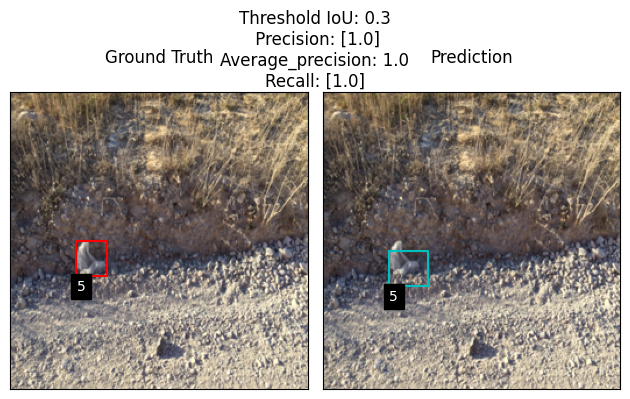

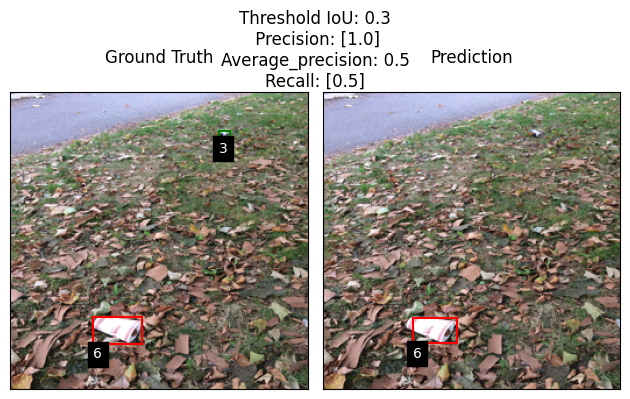

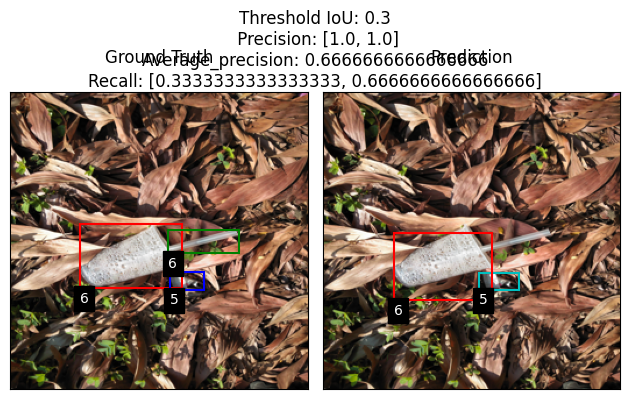

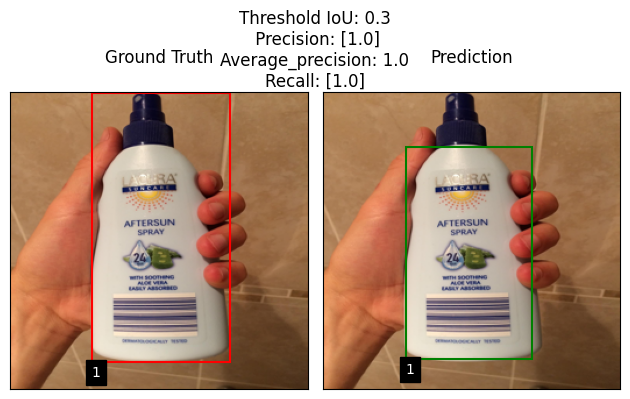

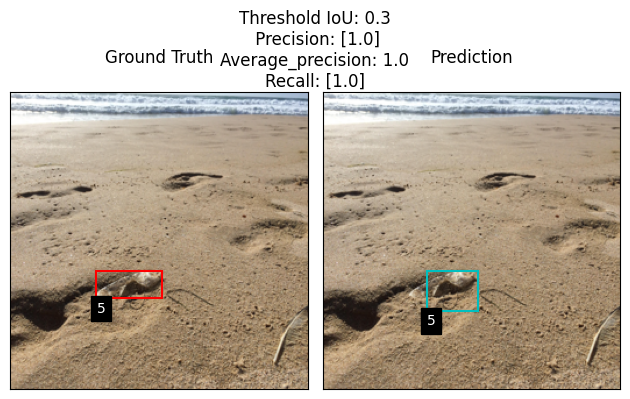

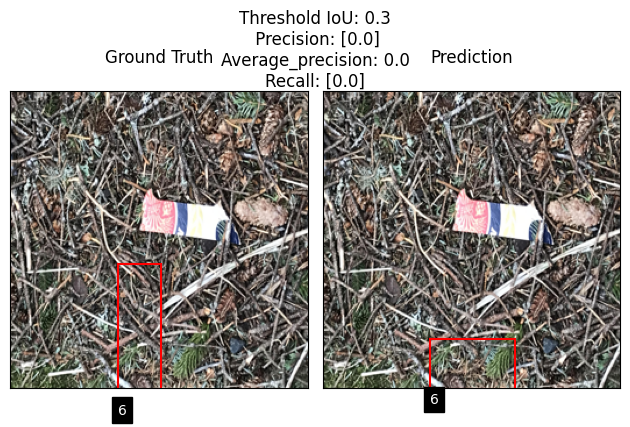

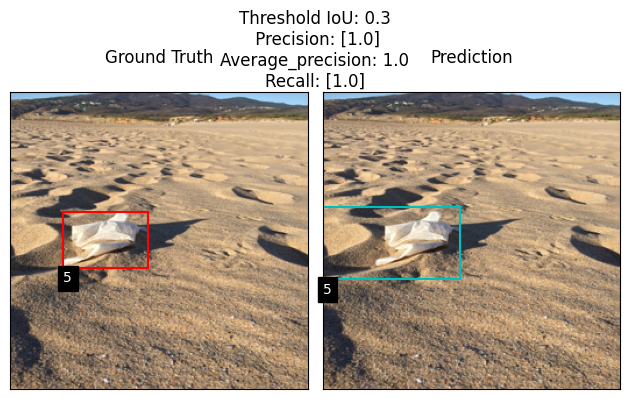

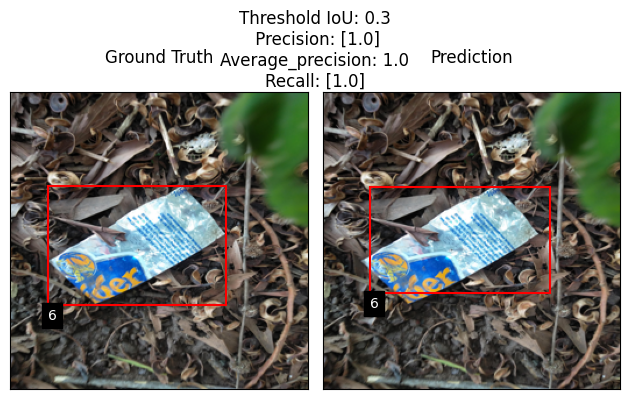

In [42]:

# print("Real bounding box and label pairs for visualization: ", real_bbox_label_image_vis)
# print("Predicted bounding box and label pairs for visualization: ", predicted_bbox_label_vis_per_image)
# print("Predicted bounding box and label pairs for visualization: ", None)

file_count = len(glob.glob("Projects/Project4/src/output_images/*"))
for idx in range(8):
    plot_image_with_boxes(real_bbox_label_image_vis[idx], predicted_bbox_label_vis[idx], f"GT_vs_pred_{idx+file_count}")

